## Load in imports and data

Last working weekly: w2024_25

In [2]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

Confirm which version of packages are setup on the notebook environment.

In [3]:
# import lsst.pipe.tasks, lsst.drp.tasks, lsst.cell_coadds
# print(lsst.pipe.tasks.__file__)
# print(lsst.drp.tasks.__file__)
# print(lsst.cell_coadds.__file__)

In [4]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508' # updated patch 61 collection
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

Patches to choose from: [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [5]:
patch = 50

In [6]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [7]:
# stitch_coadd = coadd.stitch() # fails with empty cells
explode_coadd = coadd.explode()

In [8]:
cell_list_filled = list(coadd.cells.keys())

In [9]:
cell_list = []
cells_filled = [False] * 484

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

In [10]:
# example on how to use equivalent of np.where on lists
# cell_list_test = [cell_list[index] for index, val in enumerate(cells_filled) if val == True]

In [11]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [12]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.zeros([22,22])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [13]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## 1D Cell Inputs

### Plotting cell input 1D histogram

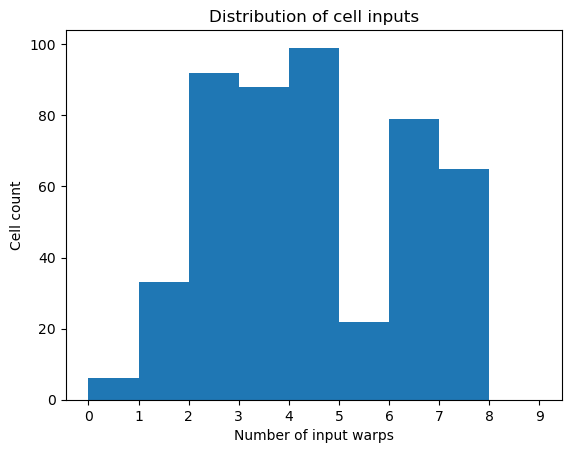

In [13]:
flat_inputs_list = inputs_list.flatten()

bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(flat_inputs_list, bins)
plt.show()

## Plot mask information

There is probably a more efficient way to do this but this is for a first try

Text(0, 0.5, 'Cell count')

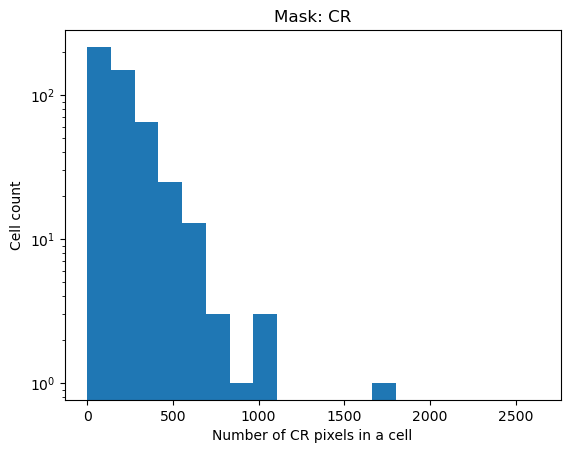

In [14]:
num_mask_pix = []
plot_mask = 'CR'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
some_cell = coadd.cells[cell_list_filled[0]]
mask_bit = some_cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list_filled:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    # optionally print cells that contain the defined masked pixels
    # if num_bad_pixels > 0:
    #     print(cell_index)
    num_mask_pix.append(num_bad_pixels)
    
num_mask_pix = np.array(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, (np.max(num_mask_pix)+1)/20)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

## Generate 2D histogram of number of cell inputs across a patch

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [31]:
# stitch_coadd.asExposure().getDimensions()

Get the grid structure of the stitched coadd:

In [32]:
# print(stitch_coadd.grid)

Plot the 2D grid of cell inputs:

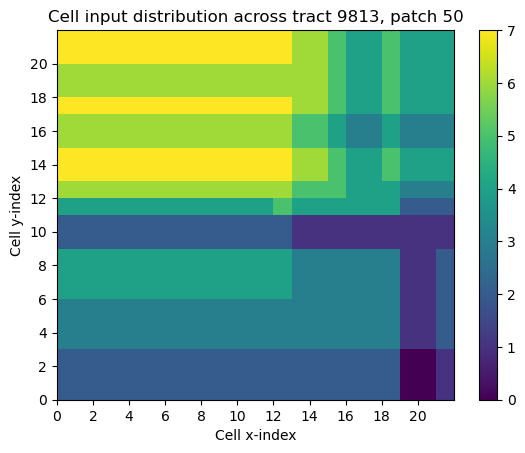

In [15]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.title(f"Cell input distribution across tract 9813, patch {patch}")
plt.xlabel("Cell x-index")
plt.ylabel("Cell y-index")
plt.colorbar()

Brief check that index of cells are lining up as expected, since numpy indexes 2D arrays differently.

In [34]:
# for patch 61
# print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
# print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
# print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

### Display above histogram over the stitched coadd

Maybe not as useful as I had hoped, but still an interesting exercise in manipulating array images.

In [35]:
# flipped_stitch = np.flip(stitch_coadd.image.getArray(), axis=0)

Many different ways to retrieve the bounding box coordinates:

In [36]:
# # coadd pixel coordinates for minimum corner and maximum corner
# print(stitch_coadd.bbox)
# # split up the four values
# print(stitch_coadd.bbox.beginX)
# print(stitch_coadd.bbox.beginY)
# print(stitch_coadd.bbox.maxX)
# print(stitch_coadd.bbox.maxY)
# # get each corner
# print(stitch_coadd.bbox.getBegin())
# print(stitch_coadd.bbox.getMax())

Remove the image padding (50 pixels added to each side, actual image should be 3300x3300 pixels:

In [37]:
# bbox = afwGeom.Box2I()
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
# cutout = stitch_coadd.asExposure()[bbox]
# print(cutout.getDimensions())

In [39]:
# from matplotlib.colors import LogNorm
# plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), alpha=0.5)
# # extent = np.min(x), np.max(x), np.min(y), np.max(y)
# extent = 0, 3300, 0, 3300
# im1 = plt.imshow(np.flip(inputs_list, axis=0), alpha=0.5, extent=extent)
# color1 = plt.colorbar(im1)
# im2 = plt.imshow(np.flip(cutout.image.getArray(), axis=0), cmap='gray', norm=LogNorm(), extent=extent)
# color2 = plt.colorbar(im2)
# plt.show()

## Cell Variance Distribution

### Plot 2D histogram of variance 
Mask cells with infinite/nan values

In [14]:
mask_mean_var_list = ma.masked_invalid(np.empty([22,22]))
mask_median_var_list = ma.masked_invalid(np.empty([22,22]))

for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
    
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mask_mean_var_list[y_index][x_index] = var_array[0][0] # insert the invalid value of inf to be masked at bottom of the cell
        mask_median_var_list[y_index][x_index] = var_array[0][0]
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mask_mean_var_list[y_index][x_index] = mean_var
    mask_median_var_list[y_index][x_index] = median_var

mask_mean_var_list = ma.masked_invalid(mask_mean_var_list)
mask_median_var_list = ma.masked_invalid(mask_mean_var_list)

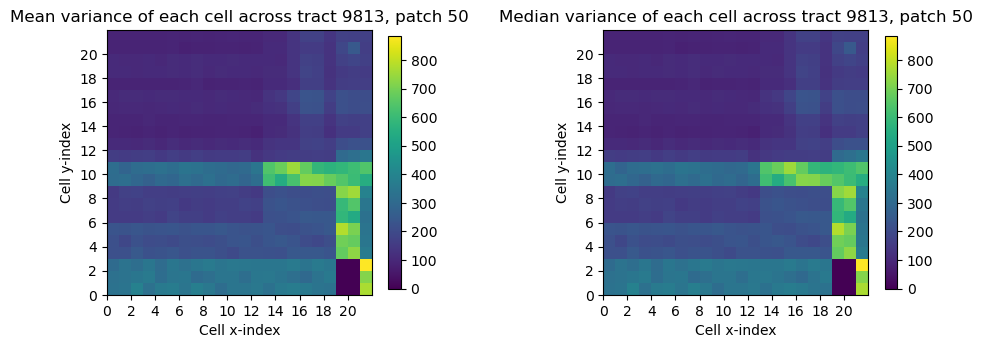

In [15]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(mask_mean_var_list, 
                               shading='auto', 
                               vmin=mask_mean_var_list.min(), 
                               vmax=mask_mean_var_list.max())
ax1.set_title(f"Mean variance of each cell across tract 9813, patch {patch}")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
                             shading='auto', 
                             vmin=mask_median_var_list.min(), 
                             vmax=mask_median_var_list.max())
ax2.set_title(f"Median variance of each cell across tract 9813, patch {patch}")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

### Compare cell input to cell variance

#### Compare the 2D histograms

First visually compare the two graphs

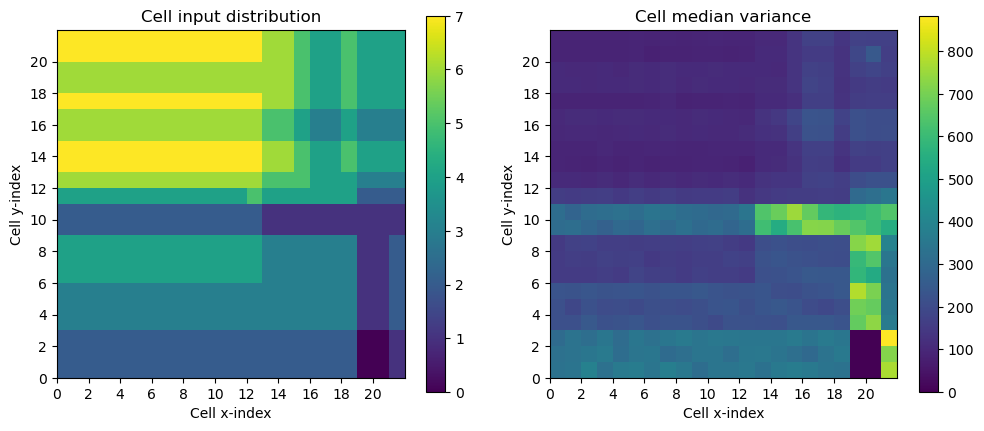

In [16]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
plt.tight_layout()

input_distrib = ax1.pcolormesh(inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max())
ax1.set_title("Cell input distribution")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.4)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
               shading='auto', 
               vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
               vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]),)
ax2.set_title("Cell median variance")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Compare directly the number of inputs to the effects in variance

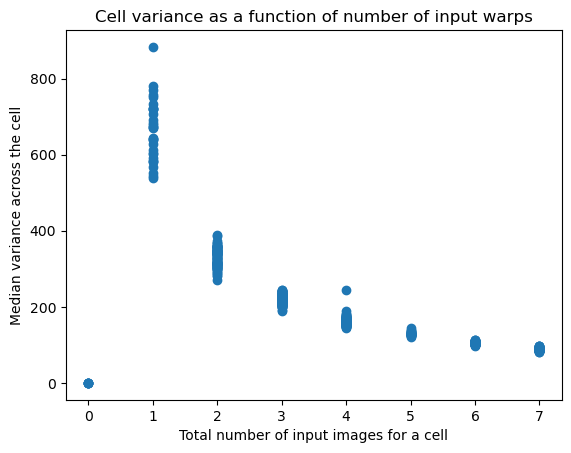

In [17]:
inputs_flat = inputs_list.flatten()
median_var_flat = mask_median_var_list.flatten()

plt.scatter(inputs_flat, median_var_flat)
plt.xlabel("Total number of input images for a cell")
plt.ylabel("Median variance across the cell")
plt.title("Cell variance as a function of number of input warps")
plt.show()

Can see now that more input images improve the variance, as expected.

### Verify weighted mean of the variance

Read in the weight of each cell using methods from `_compute_weight` in `assemble_cell_coadd`.

Iterate through the warps and their cells to determine several values for weighted means of the variance.
Only concerned with a single cell at a time for now.

In [31]:
accTask = AssembleCellCoaddTask()

weighted_var_list = []
var_coadd_list = []

var_test_cell = Index2D(x=12,y=13)

# check if cell is empty
cell_list_test = [not (var_test_cell==cell) for cell in cell_list_filled]
assert not np.all(cell_list_test), "Cell is empty"

for warp_visit in visits:
    
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)

    cell = coadd.cells[var_test_cell]
        
    # check if cell uses warp, skip cell if not
    cell_inputs = list(cell.inputs)
    cell_visits = [input.visit for input in cell_inputs]
    if not (np.isin(warp_visit, cell_visits)):
        continue
    
    x_index = var_test_cell.x
    y_index = var_test_cell.y

    bbox = cell.outer.bbox
    masked_im = warp[bbox].getMaskedImage()

    # compute weights from _compute_weight statistic
    computed_weight = accTask._compute_weight(masked_im, statsCtrl)
    
    # get the weighted var for this cell for a single pixel
    im_var_array_0 = masked_im.variance.array[0][0]
    weighted_var_list.append(computed_weight * im_var_array_0)
    # print(masked_im.mask.array[0][0] == 0) # check that the pixel doesn't have any masks (bit-value = 0)

    # get the weighted array of the variance
    weighted_var_array = computed_weight * masked_im.variance.array
    var_coadd_list.append(weighted_var_array)

    del warp

var_coadd_list = ma.masked_invalid(np.array(var_coadd_list))
var_coadd = np.nanmean(var_coadd_list, axis=0)

Compare the weighted sum from the input warps to the variance of that pixel to the cell.

0.88097006 75.37602 75.37602


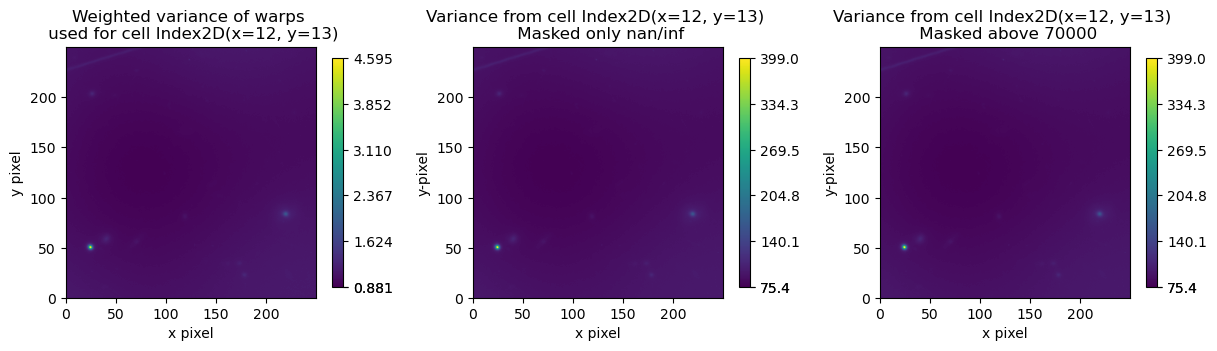

In [32]:
# get the variance from test cell
cell_0 = coadd.cells[var_test_cell]
var_0_all = ma.masked_invalid(np.array(cell_0.outer.variance.array))
var_0_small = ma.masked_greater_equal(var_0_all, 70000) # add additional mask to show range
print(var_coadd.min(), var_0_all.min(), var_0_small.min())

fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

warp_var_distrib = ax1.pcolormesh(var_coadd, 
                               shading='auto', 
                               vmin=var_coadd.min(), 
                               vmax=var_coadd.max(),)

ax1.set_title(f"Weighted variance of warps \n used for cell {var_test_cell}")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_coadd.min()
ticks1 = np.append(ticks1, np.linspace(var_coadd.min(), var_coadd.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_coadd.max())

fig.colorbar(warp_var_distrib, ax=ax1, cmap='viridis', shrink=0.2, ticks=ticks1)

cell_var_all = ax2.pcolormesh(var_0_all, 
                             shading='auto', 
                             vmin=var_0_all.min(), 
                             vmax=var_0_all.max(),)
ax2.set_title(f"Variance from cell {var_test_cell} \n Masked only nan/inf")
ax2.set_xlabel("x pixel")
ax2.set_ylabel("y-pixel")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 249, 50))
ax2.set_yticks(np.arange(0, 249, 50))
ticks2 = var_0_all.min()
ticks2 = np.append(ticks2, np.linspace(var_0_all.min(), var_0_all.max(), 5, endpoint=False))
ticks2 = np.append(ticks2, var_0_all.max())
fig.colorbar(cell_var_all, ax=ax2, cmap='viridis', shrink=0.2, ticks=ticks2)

cell_var_small = ax3.pcolormesh(var_0_small, 
                             shading='auto', 
                             vmin=var_0_small.min(),
                             vmax=var_0_small.max(),)
ax3.set_title(f"Variance from cell {var_test_cell} \n Masked above 70000")
ax3.set_xlabel("x pixel")
ax3.set_ylabel("y-pixel")
ax3.set_aspect('equal')
ax3.set_xticks(np.arange(0, 249, 50))
ax3.set_yticks(np.arange(0, 249, 50))
ticks3 = var_0_small.min()
ticks3 = np.append(ticks3, np.linspace(var_0_small.min(), var_0_small.max(), 5, endpoint=False))
ticks3 = np.append(ticks3, var_0_small.max())
fig.colorbar(cell_var_small, ax=ax3, cmap='viridis', shrink=0.2, ticks=ticks3)

plt.show()

In [33]:
neg_cell = coadd.cells[Index2D(x=14,y=19)].outer.variance.array
neg_values = neg_cell[np.where(neg_cell < 0)]
print(len(neg_values)) # should be 0!

0


#### Mask bit masks in cell variance plane

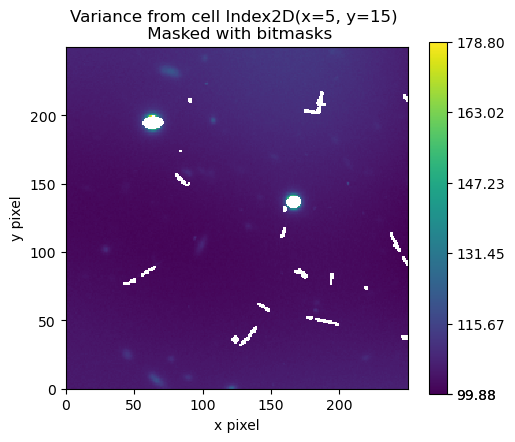

In [33]:
cell_0 = coadd.cells[var_test_cell]
cell_0_mask = cell_0.outer.mask

# create masks (elements where the mask occurs are set to True)
var_mask_intrp = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("INTRP")), True, False)
var_mask_sat = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SAT")), True, False)
var_mask_streak = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("STREAK")), True, False)
var_mask_suspect = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SUSPECT")), True, False)
var_mask_cr = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("CR")), True, False)
var_mask_nan = np.where(np.isfinite(cell_0.outer.variance.array), False, True)

# combine masks into a single mask. Any mask occuring will mask that element
all_mask = np.logical_or.reduce((var_mask_cr, var_mask_sat, var_mask_streak, var_mask_suspect, var_mask_cr, var_mask_nan))

# apply the mask to the variance plane of the cell
var_add_masks = ma.masked_array(cell_0.outer.variance.array, mask=all_mask)

fig,(ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

cell_add_masks = ax1.pcolormesh(var_add_masks, 
                               shading='auto', 
                               vmin=var_add_masks.min(), 
                               vmax=var_add_masks.max(),)

ax1.set_title(f"Variance from cell {var_test_cell} \n Masked with bitmasks")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_add_masks.min()
ticks1 = np.append(ticks1, np.linspace(var_add_masks.min(), var_add_masks.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_add_masks.max())

fig.colorbar(cell_add_masks, ax=ax1, cmap='viridis', shrink=0.8, ticks=ticks1)
plt.show()

In [37]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(cell_0.outer.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(cell_0.outer.image)

### Read in default coadds and look at variances

In [38]:
default_collection = 'u/mgorsuch/make_warp_61/20240508T162818Z'

In [39]:
default_coadd = butler.get('deepCoadd', 
                     collections=default_collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [40]:
default_var = default_coadd.getVariance()
print(np.min(default_var.array))
print(np.max(default_var.array))
print(np.max(default_var.array[np.isfinite(default_var.array)]))

0.0009985425
inf
0.090337


### Look at cell images with 1 input warp (all infs values for variance)

In [41]:
inf_cell_list = np.array([[16,3],[17,3],[15,4],[16,4],[17,4],[16,17],[17,17],[16,18],[17,18]])

See if the same warp is used for all cells with 1 input

In [42]:
for cell_index in inf_cell_list:
    warp = list(coadd.cells[Index2D(x=cell_index[0],y=cell_index[1])].inputs)
    
    if len(warp)>1:
        print("over 1 warp")
        continue
    print(f"Cell index: {cell_index}, Input visit: {warp[0].visit}")

Cell index: [16  3], Input visit: 19684
Cell index: [17  3], Input visit: 19684
Cell index: [15  4], Input visit: 19684
Cell index: [16  4], Input visit: 19684
Cell index: [17  4], Input visit: 19684
Cell index: [16 17], Input visit: 19684
Cell index: [17 17], Input visit: 19684
Cell index: [16 18], Input visit: 19684
Cell index: [17 18], Input visit: 19684


In [43]:
no_data_warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = 61,
                       visit = 19684)

In [44]:
i=8
no_data_cell = coadd.cells[Index2D(x=inf_cell_list[i][0],y=inf_cell_list[i][1])]
bbox = no_data_cell.outer.bbox
masked_im = no_data_warp[bbox].getMaskedImage()

display1 = afwDisplay.Display(frame=1)
display1.mtv(no_data_cell.outer.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(masked_im.image)

Note: all cells but 2 have the `NO_DATA` mask ([16,17] and [17,18] have only `CR`, `CROSSTALK`, `DETECTED`, and `INTRP`)

### Check DC2 run for interpolation errors in warps

In [45]:
dc2_repo = '/sdf/data/rubin/repo/dc2/'
collection_dc2 = 'u/mgorsuch/assemble_cell_coadd_patch_61/20240509T184123Z'
dc2_butler = Butler(dc2_repo)
dc2_registry = dc2_butler.registry

In [46]:
for ref in dc2_butler.registry.queryDatasets('deepCoadd_directWarp', collections=collection_dc2):
    print(ref.dataId)

{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 162699, band: 'r', day_obs: 20220806, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193147, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193189, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193232, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193233, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193888, band: 'r', day_obs: 20220917, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visi

In [47]:
warp_dc2 = dc2_butler.get('deepCoadd_directWarp',
                   collections = collection_dc2,
                   instrument='LSSTCam-imSim',
                   skymap = 'DC2_cells_v1',
                   tract = 3828,
                   patch = 42,
                   visit = 212071)

In [48]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp_dc2.maskedImage)

## Variation in INTRP mask fraction

### Create total input warp map (exclude inputs with `EDGE` mask)

Find a way to either load/calculate total number of possible input warps per cell prior to mask information.

Warps are currently thrown out in `AssembleCellCoaddTask` for:
- `EDGE` mask within cell bounding box
- weight of warp input image is not finite

There is currently no implementation for other masks.

Iteratite through the input warps and count which ones are considered for each cell. Only exclude warps with overlapping `EDGE` masks within cells. Other mask fractions will remove from total inputs early.

In [36]:
accTask = AssembleCellCoaddTask()

total_inputs_list = np.zeros([22,22])
edge = afwImage.Mask.getPlaneBitMask("EDGE")

for warp_visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)
 
    for index, cell_index in enumerate(cell_list):

        # check if the cell is filled, skip if not
        if not (cells_filled[index]):
            continue 
        
        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()

        # check if the warp covers the cell
        if (masked_im.getMask().array & edge).any():
            continue

        # ensure that weights are finite, skip cell if not
        weight = accTask._compute_weight(masked_im, statsCtrl)
        if not np.isfinite(weight):
            continue

        x_index = cell_index.x
        y_index = cell_index.y
        total_inputs_list[y_index][x_index] += 1
        
    del warp

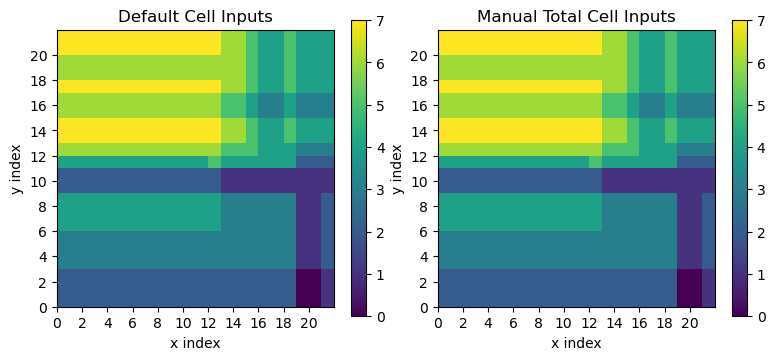

In [37]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

cell_inputs = ax1.pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

ax1.set_title(f"Default Cell Inputs")
ax1.set_xlabel("x index")
ax1.set_ylabel("y index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=ax1, cmap='viridis', shrink=0.4)

cell_total_inputs = ax2.pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   total_inputs_list, 
                                   shading='auto', 
                                   vmin=total_inputs_list.min(), 
                                   vmax=total_inputs_list.max(),)

ax2.set_title(f"Manual Total Cell Inputs")
ax2.set_xlabel("x index")
ax2.set_ylabel("y index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_total_inputs, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Now it's apparant that the default number of cell inputs that come from running the tasks produce the total number of considered inputs. It's time to rerun the above, but calculate a test mask fraction for interpolation effects.

### Implement mask fraction for interpolation

In [51]:
accTask = AssembleCellCoaddTask()

weighted_mask_frac1 = np.zeros([22,22])
cell_inputs1 = np.zeros([22,22])
cell_inputs2 = np.zeros([22,22])
intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)

    for cell_index in cell_list: 

        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()
        mask_frac_im = mask_frac_warp[bbox].array

        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(visit, cell_visits)):
            continue

        # skip warp for this cell if intrp mask fraction is too high
        total_pixels = bbox.area
        mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels

        if mask_frac >= 0.85:
            print("mask frac reached")
            continue

        # coadd the weighted mask fraction for this cell
        input_weight = accTask._compute_weight(masked_im, statsCtrl)
        weight_mask_frac = input_weight * mask_frac_im
        
        x_index = cell_index.x
        y_index = cell_index.y

        weighted_mask_frac1[y_index][x_index] += np.nansum(weight_mask_frac) / total_pixels
        
        if mask_frac >= 0.10:
            continue
            
        cell_inputs1[y_index][x_index] += 1

        if mask_frac >= 0.05:
            continue
    
        cell_inputs2[y_index][x_index] += 1

    del warp
    del mask_frac_warp

cell_input_frac1 = cell_inputs1 / inputs_list
cell_input_frac2 = cell_inputs2 / inputs_list

Cut out the exta 50 empty side pixels in the stitched coadd.

In [52]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = stitch_coadd.asExposure()[bbox]

extent = 0, cutout.getDimensions()[0], 0, cutout.getDimensions()[1]

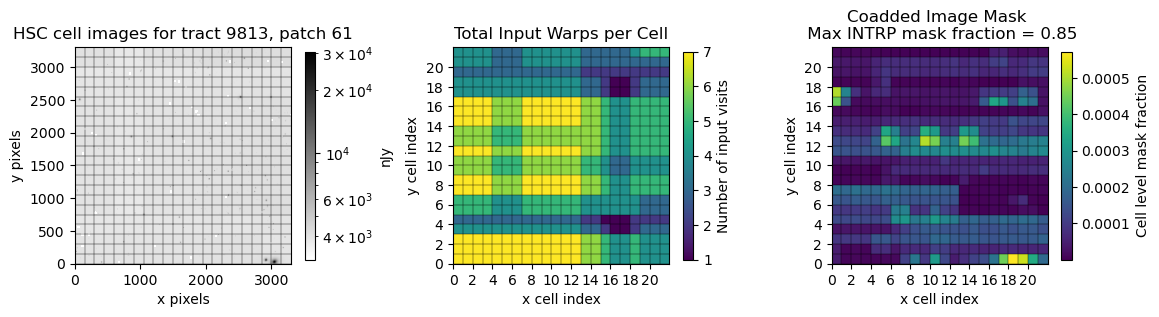

In [53]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig, axs = plt.subplots(1, 3, figsize=(11,11))
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.05)

stitched_image = axs[0].imshow(np.flip(cutout.image.array, axis=0),
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [axs[0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [axs[0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

axs[0].set_title(f"HSC cell images for tract 9813, patch {patch}")
axs[0].set_xlabel("x pixels")
axs[0].set_ylabel("y pixels")
axs[0].set_aspect('equal')

fig.colorbar(stitched_image, ax=axs[0], cmap='viridis', shrink=0.2, label="nJy")

cell_inputs = axs[1].pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [axs[1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1].set_title(f"Total Input Warps per Cell")
axs[1].set_xlabel("x cell index")
axs[1].set_ylabel("y cell index")
axs[1].set_aspect('equal')
axs[1].set_xticks(np.arange(0, 21, 2))
axs[1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=axs[1], cmap='viridis', shrink=0.2, label="Number of input visits")

cell_mask_frac1 = axs[2].pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   weighted_mask_frac1,
                                   shading='auto', 
                                   vmin=weighted_mask_frac1.min(), 
                                   vmax=weighted_mask_frac1.max(),)

hlines = [axs[2].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[2].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[2].set_title(f"Coadded Image Mask \n Max INTRP mask fraction = 0.85")
axs[2].set_xlabel("x cell index")
axs[2].set_ylabel("y cell index")
axs[2].set_aspect('equal')
axs[2].set_xticks(np.arange(0, 21, 2))
axs[2].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=axs[2], cmap='viridis', shrink=0.2, label="Cell level mask fraction")

plt.savefig("image_outputs/2d-weighted-mask-fraction.png", bbox_inches='tight')
plt.show()

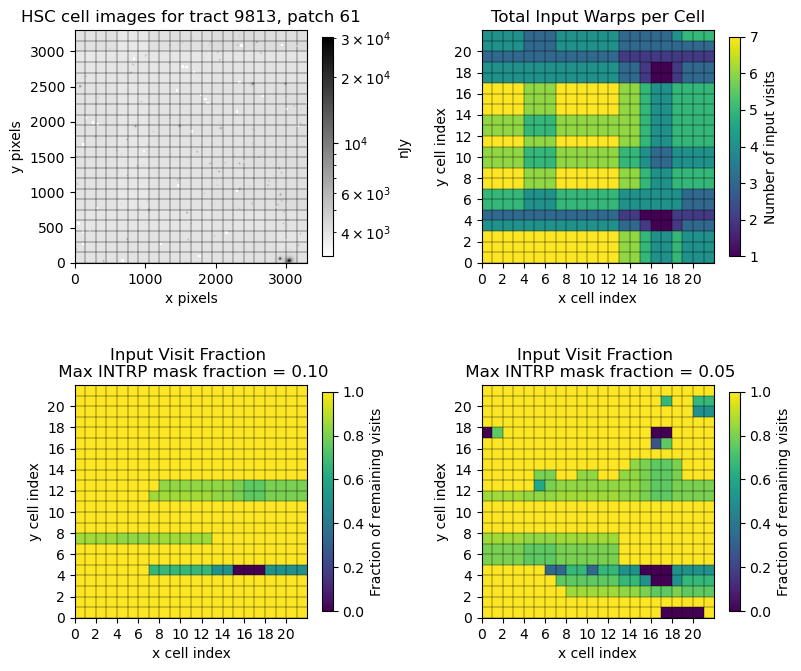

In [54]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig, axs = plt.subplots(2, 2, figsize=(9,9))
plt.subplots_adjust(wspace=0.4, hspace=0.05)

stitched_image = axs[0,0].imshow(np.flip(cutout.image.array, axis=0), 
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [axs[0,0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [axs[0,0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

axs[0,0].set_title(f"HSC cell images for tract 9813, patch {patch}")
axs[0,0].set_xlabel("x pixels")
axs[0,0].set_ylabel("y pixels")
axs[0,0].set_aspect('equal')

fig.colorbar(stitched_image, ax=axs[0,0], cmap='viridis', shrink=0.65, label="nJy")

cell_inputs = axs[0,1].pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [axs[0,1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[0,1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[0,1].set_title(f"Total Input Warps per Cell")
axs[0,1].set_xlabel("x cell index")
axs[0,1].set_ylabel("y cell index")
axs[0,1].set_aspect('equal')
axs[0,1].set_xticks(np.arange(0, 21, 2))
axs[0,1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=axs[0,1], cmap='viridis', shrink=0.65, label="Number of input visits")

cell_mask_frac1 = axs[1,0].pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   cell_input_frac1, 
                                   shading='auto', 
                                   vmin=0, 
                                   vmax=1,)

hlines = [axs[1,0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1,0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1,0].set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.10")
axs[1,0].set_xlabel("x cell index")
axs[1,0].set_ylabel("y cell index")
axs[1,0].set_aspect('equal')
axs[1,0].set_xticks(np.arange(0, 21, 2))
axs[1,0].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=axs[1,0], cmap='viridis', shrink=0.65, label="Fraction of remaining visits")

cell_mask_frac2 = axs[1,1].pcolormesh(x_cell_bin, 
                                       y_cell_bin,
                                       cell_input_frac2, 
                                       shading='auto', 
                                       vmin=0, 
                                       vmax=1,)

hlines = [axs[1,1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1,1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1,1].set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.05")
axs[1,1].set_xlabel("x cell index")
axs[1,1].set_ylabel("y cell index")
axs[1,1].set_aspect('equal')
axs[1,1].set_xticks(np.arange(0, 21, 2))
axs[1,1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac2, ax=axs[1,1], cmap='viridis', shrink=0.65, label="Fraction of remaining visits")

# plt.savefig("image_outputs/2d-mask-fraction.png", bbox_inches='tight')
plt.show()

### Mask Fraction Function

Get the mask fraction for each warp in each of the cells.
Should only have to run once per notebook session.

In [55]:
accTask = AssembleCellCoaddTask()

warp_mask_fractions = [np.zeros([22,22]) for i in np.arange(len(visits))]

intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for index, visit in enumerate(visits):
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    cell_grid = np.zeros([22,22])

    for cell_index in cell_list: 

        cell = coadd.cells[cell_index]

        x_index = cell_index.x
        y_index = cell_index.y
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()
        mask_frac_im = mask_frac_warp[bbox].array

        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(visit, cell_visits)):
            cell_grid[y_index][x_index] = -1.0
            continue
    
        # calculate fraction of masked pixels for the area of the warp that covers this cell
        total_pixels = bbox.area
        mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels
    
        cell_grid[y_index][x_index] = mask_frac

    warp_mask_fractions[index] = cell_grid

    del warp
    del mask_frac_warp

Iterate through the each max mask threshold to see how number of inputs change

In [56]:
max_mask_frac_list = np.arange(0.01, 0.20, 0.02)
cell_inputs_grid_total = [np.zeros([22,22]) for i in np.arange(len(max_mask_frac_list))]

intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for warp_index, warp_mask_fraction in enumerate(warp_mask_fractions):

    for index, max_mask_frac in enumerate(max_mask_frac_list):
    
        cell_inputs_grid = np.zeros([22,22])

        for cell_index in cell_list: 

            x_index = cell_index.x
            y_index = cell_index.y

            mask_frac = warp_mask_fraction[y_index][x_index]

            # skip this warp if cell is not in warp (defined with -1)
            if (mask_frac == -1.0):
                continue

            # skip this warp if its mask fraction is over the threshold
            if mask_frac >= max_mask_frac:
                continue
            
            # add one input to this cell if the warp passes mask criteria
            cell_inputs_grid[y_index][x_index] += 1

        # add the 22 x 22 cell grid for this mask threshold to the list of cell grids
        cell_inputs_grid_total[index] += cell_inputs_grid
        
cell_inputs_grid_total = [array.flatten() for array in cell_inputs_grid_total]
cell_inputs_remaining_frac = [(array/inputs_list.flatten()) for array in cell_inputs_grid_total]
cell_inputs_removed_frac = [(1-(array/inputs_list.flatten())) for array in cell_inputs_grid_total]

cell_inputs_grid_mean_total = [np.mean(array) for array in cell_inputs_grid_total]
cell_inputs_mean_remaining_frac = [np.mean(array) for array in cell_inputs_remaining_frac]
cell_inputs_mean_removed_frac = [np.mean(array) for array in cell_inputs_removed_frac]

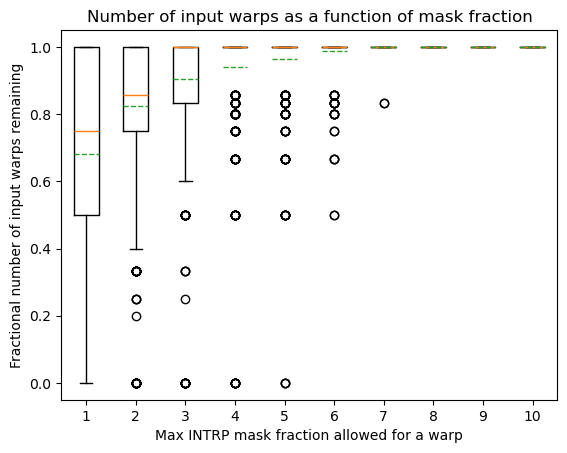

In [57]:
fig, ax = plt.subplots()
bplot = ax.boxplot(cell_inputs_remaining_frac, 
                   showmeans = True,
                   meanline = True,)
ax.set_title("Number of input warps as a function of mask fraction")
ax.set_xlabel("Max INTRP mask fraction allowed for a warp")
ax.set_ylabel("Fractional number of input warps remaining")
#ax.set_yscale("log")
plt.show()

Try a culminative version of the plot above (squish information down into one value for each mask fraction)

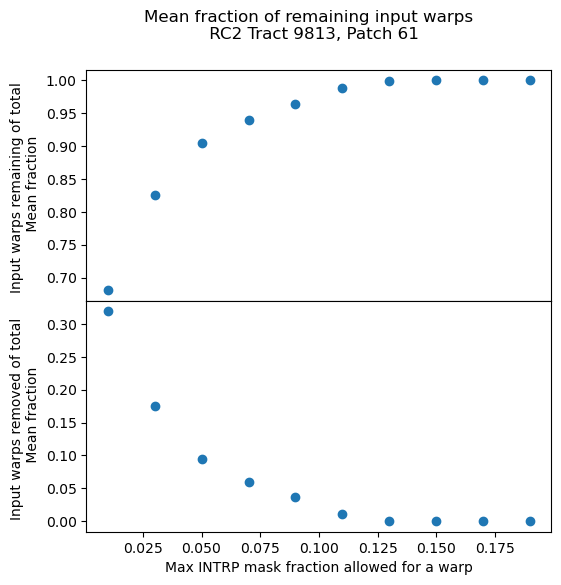

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True)

#plt.tight_layout(pad=0)
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
fig.subplots_adjust(hspace=0)
fig.suptitle(f"Mean fraction of remaining input warps \n RC2 Tract 9813, Patch {patch}")

remaining = axs[0].scatter(max_mask_frac_list, cell_inputs_mean_remaining_frac,)
axs[0].set_ylabel("Input warps remaining of total \n Mean fraction")
#ax.set_xscale("log")

removed = axs[1].scatter(max_mask_frac_list, cell_inputs_mean_removed_frac,)
axs[1].set_xlabel("Max INTRP mask fraction allowed for a warp")
axs[1].set_ylabel("Input warps removed of total \n Mean fraction")

plt.show()

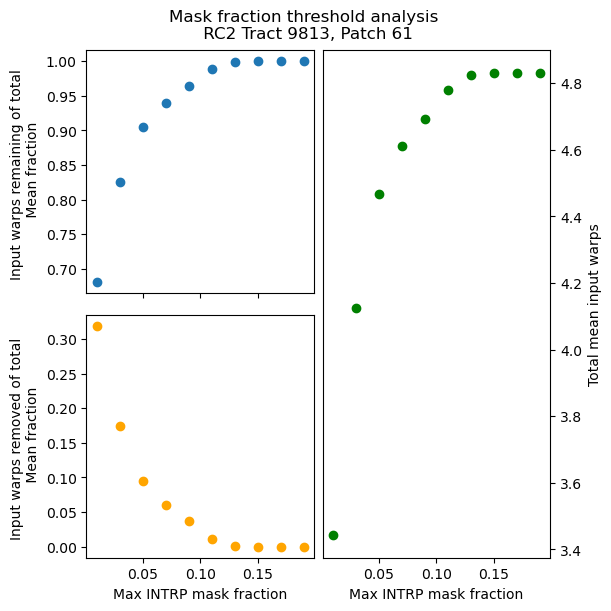

In [59]:
fig, axd = plt.subplot_mosaic([['remain', 'total'],
                               ['removed', 'total']],
                              figsize=(6, 6), layout="constrained", sharex=True)

fig.suptitle(f"Mask fraction threshold analysis \n RC2 Tract 9813, Patch {patch}")

axd['remain'].scatter(max_mask_frac_list, cell_inputs_mean_remaining_frac,)
axd['remain'].set_ylabel("Input warps remaining of total \n Mean fraction")

axd['removed'].scatter(max_mask_frac_list, cell_inputs_mean_removed_frac, color='orange')
axd['removed'].set_xlabel("Max INTRP mask fraction")
axd['removed'].set_ylabel("Input warps removed of total \n Mean fraction")

axd['total'].scatter(max_mask_frac_list, cell_inputs_grid_mean_total, color='green')
axd['total'].set_xlabel("Max INTRP mask fraction")
axd['total'].set_ylabel("Total mean input warps")
axd['total'].yaxis.set_label_position("right")
axd['total'].yaxis.tick_right()
# axd['total'].set_ylabel("Input warps removed of total \n Mean fraction")

plt.show()

## Cell Depth

### Cell Depth Methods

Example calculations for values needed to calculate cell cepth.

Image depth equation from https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/healSparseMappingProperties.py#L485

In [30]:
# returns effective PSF area given the PSF stamp image array
def psfArea(psf_im):
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    return numer/denom

In [31]:
# returns the weight (~1/meanVar) of a cell, given the cell object and the statistics settings
def cell_weight(cell, statsCtrl):
    accTask = AssembleCellCoaddTask()
    mask_im = cell.outer.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    return computed_weight

In [32]:
# returns the limiting PSF magnitude of each pixel, given the PSF area and cell weight
def mag_lim(psf_area, weights, zp=27, num_sigma=5):
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/weights))
    return maglim

Example on test cell:

In [33]:
depth_cell = coadd.cells[Index2D(x=0,y=0)]
depth_psf_image = depth_cell.psf_image.array
psf_area = psfArea(depth_psf_image)
print("PSF eff. area: ", psf_area)
print("Cell weight: ", cell_weight(depth_cell, statsCtrl))
print("Cell depth: ", np.mean(mag_lim(psf_area, cell_weight(depth_cell, statsCtrl))))

PSF eff. area:  33.79581669988944
Cell weight:  0.003035305399052906
Cell depth:  20.194249299742403


### Cell Depth 2D Distribution

In [54]:
cell_depths = np.empty([22,22])

for index, cell_index in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 

    cell = coadd.cells[cell_index]
    psf_im = cell.psf_image.array

    psf_area = psfArea(psf_im)
    weight = cell_weight(cell, statsCtrl)
    
    cell_depth = mag_lim(psf_area, weight)

    x_index = cell_index.x
    y_index = cell_index.y
    
    cell_depths[y_index][x_index] = np.mean(cell_depth)

cell_depths = ma.masked_where(cell_depths < 0.1, cell_depths) # TO-DO: remove hard coded condition

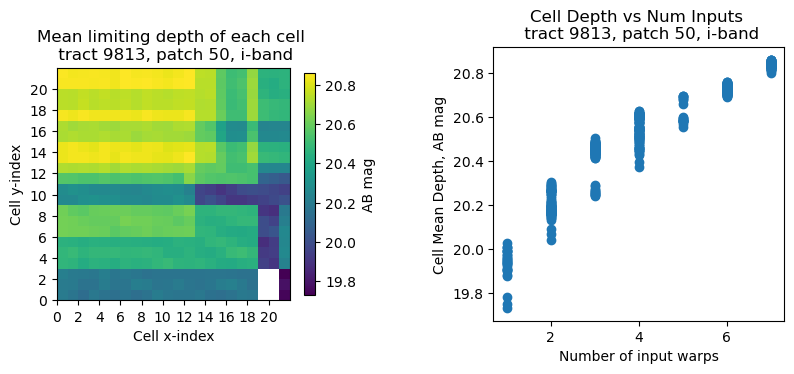

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

depths = axs[0].pcolormesh(cell_depths, 
                        shading='auto', 
                        vmin=ma.min(cell_depths), 
                        vmax=ma.max(cell_depths),)

axs[0].set_title(f"Mean limiting depth of each cell \n tract 9813, patch {patch}, i-band")
axs[0].set_xlabel("Cell x-index")
axs[0].set_ylabel("Cell y-index")
axs[0].set_aspect('equal')
axs[0].set_xticks(np.arange(0, 21, 2))
axs[0].set_yticks(np.arange(0, 21, 2))
fig.colorbar(depths, ax=axs[0], cmap='viridis', shrink=0.3, label='AB mag')

depths = axs[1].scatter(inputs_list.flatten(), cell_depths)

axs[1].set_title(f"Cell Depth vs Num Inputs \n tract 9813, patch {patch}, i-band")
axs[1].set_aspect(12)
axs[1].set_xlabel("Number of input warps")
axs[1].set_ylabel("Cell Mean Depth, AB mag")
axs[1].set_aspect(5)

Fortunately, the limiting depth seems to improve as number of input images increases. Unsure of why the magnitudes are so low, this is a deep field image...